In [1]:
import json

from pathlib import Path

import wandb
import pandas as pd
import numpy as np
import seaborn as sns

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils


float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

_ = sns.set(style="darkgrid", palette="colorblind")

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style("white")

# Matplotlib params
from matplotlib import rcParams
from matplotlib import rc

rcParams['legend.loc'] = 'best'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rc('text', usetex=False)

In [3]:
def set_axes(ax, xlim, ylim, xlabel, ylabel):
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  ax.set_xlabel(xlabel, labelpad=14)
  ax.set_ylabel(ylabel, labelpad=14)
 
def set_ticks(ax, xticks, xticklabels, yticks, yticklabels):
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticklabels)
  ax.set_yticks(yticks)
  ax.set_yticklabels(yticklabels)

def decorate_axis(ax, wrect=10, hrect=10, labelsize='large'):
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_linewidth(2)
  ax.spines['bottom'].set_linewidth(2)
  # Deal with ticks and the blank space at the origin
  ax.tick_params(length=0.1, width=0.1, labelsize=labelsize)
  # Pablos' comment
  ax.spines['left'].set_position(('outward', hrect))
  ax.spines['bottom'].set_position(('outward', wrect))

In [5]:
envs = [
    "Acrobot-v1",
    "CartPole-v1",
    "MountainCarContinuous-v0",
    "Pendulum-v1",
]

methods = [
    "ppo",
    "vsop",
    "a3c",
]

base_dir = Path().resolve() / "output"

data_dict = {}
for method in methods:
    method_output = {}
    for env in envs:
        path = base_dir / f"{env}/{method}/"
        returns = np.load(path / "returns.npy")
        method_output.update({env: list(returns[:, -100:].mean(-1))})
        print(f"{method}, {env}: {returns[:, -100:].mean():.02f}")
    data_dict.update({method: method_output})


ppo, Acrobot-v1: -80.72
ppo, CartPole-v1: 492.40
ppo, MountainCarContinuous-v0: -0.00
ppo, Pendulum-v1: -386.54
vsop, Acrobot-v1: -81.51
vsop, CartPole-v1: 489.43
vsop, MountainCarContinuous-v0: 46.78
vsop, Pendulum-v1: -554.59
a3c, Acrobot-v1: -83.90
a3c, CartPole-v1: 446.69
a3c, MountainCarContinuous-v0: -5.06
a3c, Pendulum-v1: -617.67


In [6]:
for method, data in data_dict.items():
    for environment, scores in data.items():
        nan_mask = np.isnan(scores)
        for i, is_nan in enumerate(nan_mask):
            if is_nan:
                data_dict[method][environment][i] = np.nanmedian(scores)

In [7]:
def score_normalization(res_dict, min_scores, max_scores):
  norm_scores = {}
  for game, scores in res_dict.items():
    norm_scores[game] = (np.array(scores) - min_scores[game])/(max_scores[game] - min_scores[game])
  return norm_scores

def convert_to_matrix(score_dict):
   keys = sorted(list(score_dict.keys()))
   return np.stack([score_dict[k] for k in keys], axis=1)

In [8]:
IQM = lambda x: metrics.aggregate_iqm(x) # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0) # Optimality Gap
MEAN = lambda x: metrics.aggregate_mean(x)
MEDIAN = lambda x: metrics.aggregate_median(x)

In [9]:
# Create PPO Normalization
MEAN_PPO_SCORES = {key: np.mean(val) for key, val in data_dict['ppo'].items()}
ZERO_SCORES = {key: 0.0 for key in envs}
ppo_normalize = lambda scores: score_normalization(
    scores, ZERO_SCORES, MEAN_PPO_SCORES
)

algorithms = list(data_dict.keys())
norm_data = {'ppo': {}}
for method in algorithms:
  scores = data_dict[method]
  norm_data['ppo'][method] = convert_to_matrix(
      ppo_normalize(scores)
    )

In [10]:
ppo_scores = norm_data['ppo']
aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    ppo_scores, aggregate_func, reps=50000)

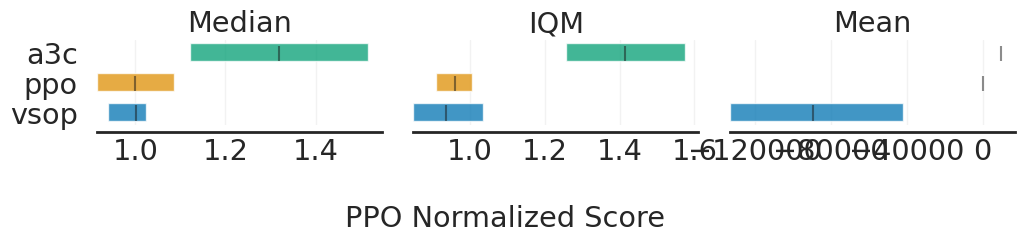

In [11]:
algorithms = ["vsop", "ppo", "a3c"]
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Mean'],
    algorithms=algorithms,
    xlabel_y_coordinate=-0.8,
    xlabel='PPO Normalized Score')

plt.show()

In [21]:
pairs = [
  ['vsop', 'ppo'],
  ["vsop", "a3c"],
]

algorithm_pairs = {}
for pair in pairs[::-1]:
  d1 = norm_data['ppo'][pair[0]]
  d2 = norm_data['ppo'][pair[1]]
  # d_concat = np.concatenate((d1, d2), axis=-1)
  algorithm_pairs['_'.join(pair)] = (d1, d2)

probabilities, probability_cis = rly.get_interval_estimates(
    algorithm_pairs, metrics.probability_of_improvement, reps=2000)

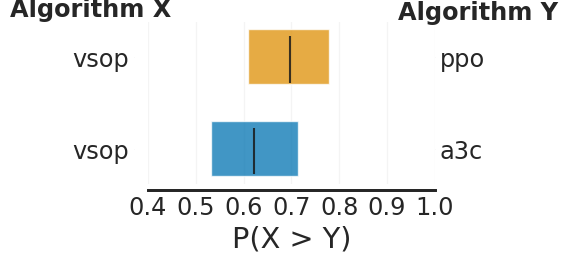

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.1))
h = 0.6

ax2 = ax.twinx()
colors = sns.color_palette('colorblind')

for i, (pair, p) in enumerate(probabilities.items()):  
  (l, u), p  = probability_cis[pair], p

  ax.barh(y=i, width=u-l, height=h, 
          left=l, color=colors[i], 
          alpha=0.75, label=pair[0])
  ax2.barh(y=i, width=u-l, height=h, 
          left=l, color=colors[i], 
          alpha=0.0, label=pair[1])
  ax.vlines(x=p, ymin=i-7.5 * h/16, ymax=i+(6*h/16),
            color='k', alpha=0.85)
  

ax.set_yticks(list(range(len(pairs))))
ax2.set_yticks(range(len(pairs)))
pairs = [x.split('_') for x in probabilities.keys()]
ax2.set_yticklabels([pair[1] for pair in pairs], fontsize='large')
ax.set_yticklabels([pair[0] for pair in pairs], fontsize='large')
ax2.set_ylabel('Algorithm Y', fontweight='bold', rotation='horizontal', fontsize='x-large')
ax.set_ylabel('Algorithm X', fontweight='bold', rotation='horizontal', fontsize='x-large')
ax.set_xticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.yaxis.set_label_coords(-0.2, 1.0)
ax2.yaxis.set_label_coords(1.15, 1.13)
decorate_axis(ax, wrect=5)
decorate_axis(ax2, wrect=5)
       
ax.tick_params(axis='both', which='major', labelsize='x-large')
ax2.tick_params(axis='both', which='major', labelsize='x-large')
ax.set_xlabel('P(X > Y)', fontsize='xx-large')
ax.grid(axis='x', alpha=0.2)
plt.subplots_adjust(wspace=0.05)
ax.spines['left'].set_visible(False)
ax2.spines['left'].set_visible(False)


plt.show()